In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

# import time
import pyeeg

import tools

In [2]:
Pkl_Filename = '../data/raw_data_recording-8ch-3.pkl'
data_from_file = []
with open(Pkl_Filename, 'rb') as file:
    data_from_file = pickle.load(file)
    
channels = ['T3', 'F7', 'Fp1', 'Fp2', 'F8', 'F4', 'F3', 'T4'] # Data set 3

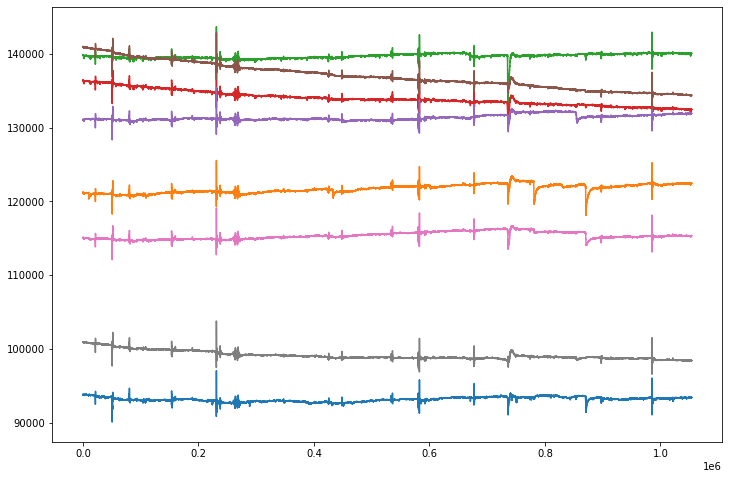

In [3]:
sorted_data = tools.assemble_sort_raw_data(data_from_file)
event_list = tools.get_event_list(sorted_data, ignored=[9])
ch_sel = list(range(1,9))
t_sel = [22]

tools.plot_all_channels(sorted_data[ch_sel])

#### No need for scaling as brainflow returns uV

/Users/colinwageman/opt/anaconda3/lib/python3.8/site-packages/neurodsp/filt/filter.py:96: UserWarning: Edge artifacts are not removed when using an IIR filter.
  warn('Edge artifacts are not removed when using an IIR filter.')
/Users/colinwageman/opt/anaconda3/lib/python3.8/site-packages/neurodsp/filt/utils.py:90: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))
/Users/colinwageman/opt/anaconda3/lib/python3.8/site-packages/neurodsp/filt/checks.py:172: UserWarning: Transition bandwidth is  40.2  Hz. This is greater than the desiredpass/stop bandwidth of  29.0 Hz
  warn('Transition bandwidth is  {:.1f}  Hz. This is greater than the desired'\


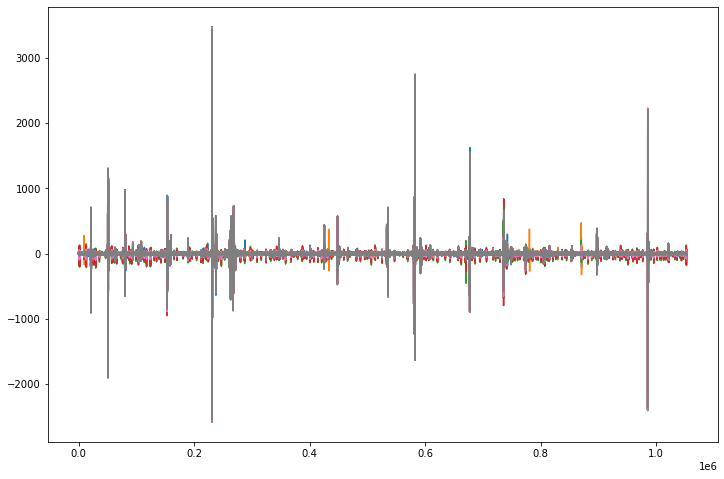

In [4]:
ch_data = tools.filter_eeg(sorted_data[ch_sel], 250, (1,30))
tools.plot_all_channels(ch_data)

### Haha! I sneezed during the recording, can you see where?
After some searching, the sneeze happened on the 78th regular event. `i=77` after removing blink events.<br>
With blink events, `i=78`

In [5]:
# after a visual look over, 3 events seem worth removing
# the sneeze and two others that were probably head movement.
sneeze = 77
bad_events = [59, sneeze, 107]
good_events =  [i for i in range(len(event_list[1:-1])) if i not in bad_events]

fs = 250
dt = 1000/fs
sdt = np.round(dt).astype(int) # should be 4ms/dt
baseline_duration = int(100 / sdt) # ms
erp_start = int(200 / sdt)
erp_end = int(500 / sdt)
duration = int(2000 / sdt)
total = baseline_duration + duration
lin_time = np.linspace(-100,2000, total)
blink_duration = int(4000 / sdt)

epoched_data = []
blinks = []
for ev in event_list:
    # every event except blink events
    if ev[2] != 5:
        event_time = int(ev[0] * fs)
        start = event_time - baseline_duration
        stop = event_time + duration
        data = np.array(ch_data[:, start:stop])
        data = data.T - np.mean(data.T, 0)
        data = data - np.mean(data[:baseline_duration, :], 0)
        epoched_data.append(data.T)
    else:
        event_time = int(ev[0] * fs)
        start = event_time
        stop = event_time + blink_duration
        data = np.array(ch_data[:, start:stop])
#         data = data.T - np.mean(data.T, 0)
#         data = data - np.mean(data[:baseline_duration, :], 0)
        blinks.append(data)
        
events = np.array(event_list[1:-1]) # skip blink events
events[:,0] = events[:,0] * fs
events = events.astype(int)

events = events[good_events]
epoched_data = [epoched_data[i] for i in good_events]

comp. thresh: 0.08254554542397607
0.1100200258331125
3.479138698631995


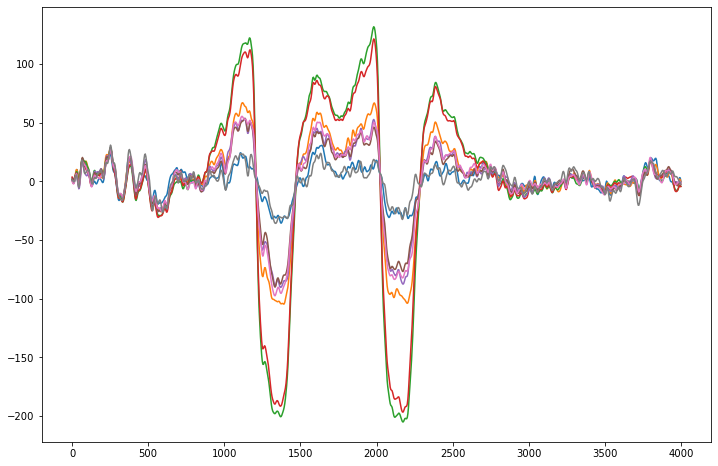

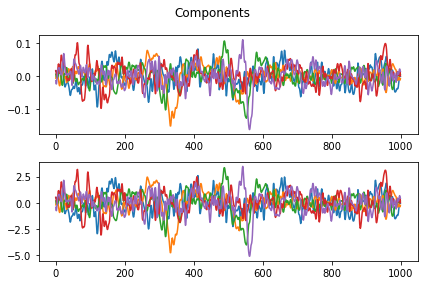

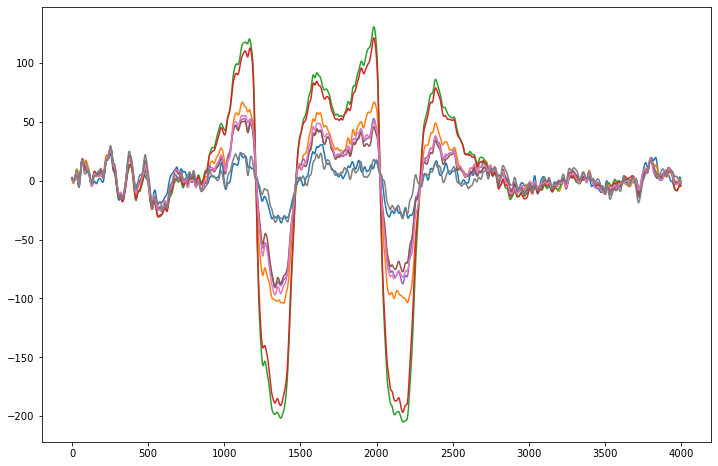

In [23]:
from sklearn.decomposition import FastICA

class ICAFilter:
    """Get ICA mixing and unmixing matrices.
        Uses sklearn FastICA
    """
    def __init__(self, ch_data_segment, threshold=0.05, n_components=5, iter_limit=200, component_thr=None):
        self.analysis_epoch = ch_data_segment
        self.threshold = component_thr if component_thr is not None else threshold
        self.iter_limit = iter_limit
        
        if len(ch_data_segment) < n_components:
            n_components = len(ch_data_segment)
            
        self.n_components = n_components
        
    def fit(self):
        """When using sklearn FastICA, data should be shaped as (samples x channels)
            That is also the format of it's transform option. This ICAFilter favors
            a format of (channels x samples). Along with mixing matrices, you will
            see the occasional '.T' to transpose the data.
        """
        self.ica  = FastICA(n_components=self.n_components, max_iter=self.iter_limit)
        transformed = self.ica.fit_transform(self.analysis_epoch.T)
        unmixing = self.ica.components_
        thesh = np.ones((self.analysis_epoch.shape[0], 1)) * self.threshold
        # print(unmixing.shape)
        # print(thesh.shape)
        thresh_transform = max(abs(np.dot(unmixing, thesh)[:,0]))
        print('comp. thresh:', thresh_transform)
        # print(thresh_transform)
        # print(transformed.shape)
        # filter_ch = get_theshold_greatest(transformed.T, thresh_transform)
        for comp in transformed.T:
            std = np.std(comp)
            u = np.mean(comp)
            comp = (comp - u)/ std

        # filter_ch = transformed.T
        # filter channel by modifying mix and unmix matrices
        mixing = self.ica.mixing_
        # print(filter_ch)
        # print(mixing.shape)
        # mixing[:,filter_ch] = 0
        self.cleaning_matrix = np.dot(mixing, unmixing)
        
    def clean(self, ch_data):
        return np.dot(self.cleaning_matrix, ch_data)

    def plot_components(self):
        fig, ax = plt.subplots(2)
        fig.suptitle('Components')
        transformed = np.dot(self.ica.components_, self.analysis_epoch).T
        for sig in transformed.T:
            ax[0].plot(sig)
        print(np.max(transformed))
        new = []
        for comp in transformed.T:
            std = np.std(comp)
#             print(std)
            u = np.mean(comp)
#             print(u)
            new.append(comp / std)

        new = np.array(new).T
        print(np.max(new))
        for sig in new.T:
            ax[1].plot(sig)

        plt.tight_layout()
        plt.show()


# close up of eye blinks
tools.plot_all_channels(blinks[0])

blink_filter = ICAFilter(blinks[0], threshold=20, n_components=5, iter_limit=5000)
blink_filter.fit()
blink_filter.plot_components()
        
cleaned = blink_filter.clean(blinks[0])
tools.plot_all_channels(cleaned)



Number of mental "Hey Brain" instances: 35
Number of verbal "Hey Brain" instances: 32
Number of epochs: 137


<Figure size 864x576 with 0 Axes>

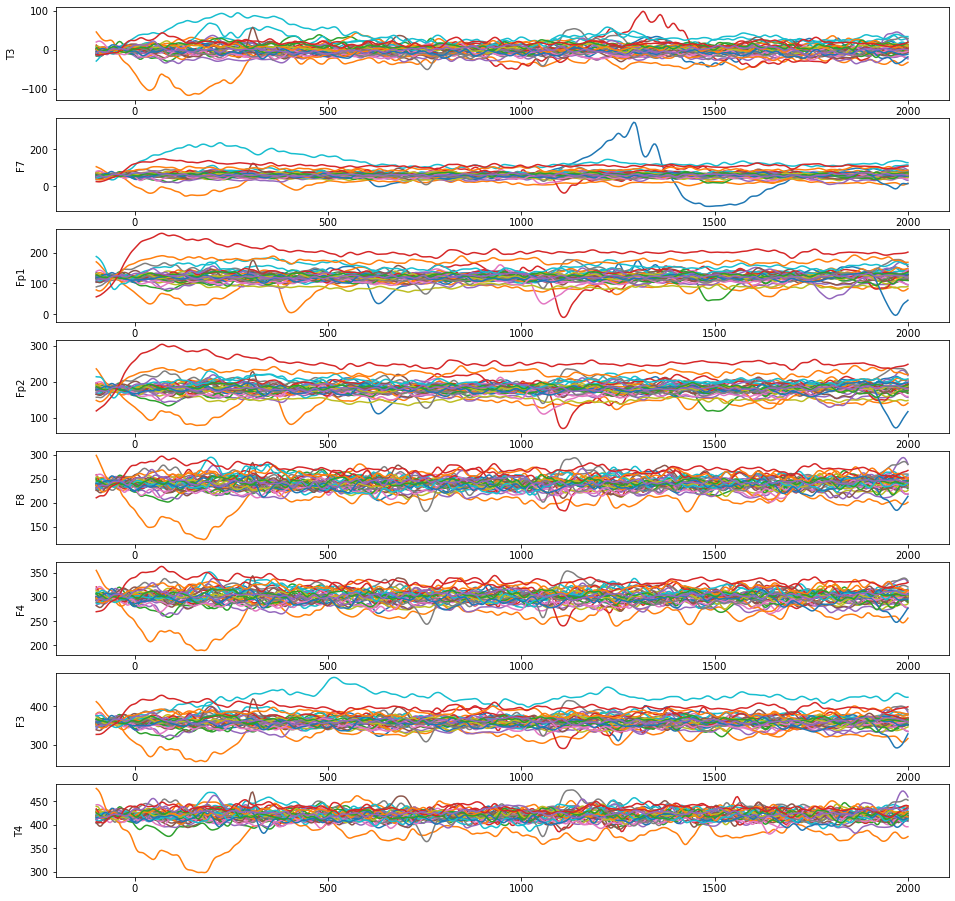

In [7]:
epochs = np.array(epoched_data)

think = epochs[np.where(events[:,2] == 2)]
say = epochs[np.where(events[:,2] == 1)]
figure(figsize=(12,8))
fig, ax = plt.subplots(8, 1, figsize=(16,16))
for ep in think:
    i = 0
    for ch in ep:
        ax[i].plot(lin_time, ch + (i*60))
        i += 1
for graph, ch  in zip(ax, channels):
    graph.set_ylabel(ch)
    
print('Number of mental "Hey Brain" instances:', len(think))
print('Number of verbal "Hey Brain" instances:', len(say))
print('Number of epochs:', len(epochs))

### Feature Establishing

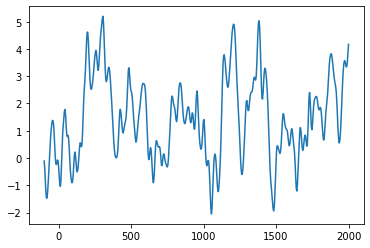

In [8]:
avg_think = np.mean(think,0)
plt.plot(lin_time, np.mean(avg_think,0))

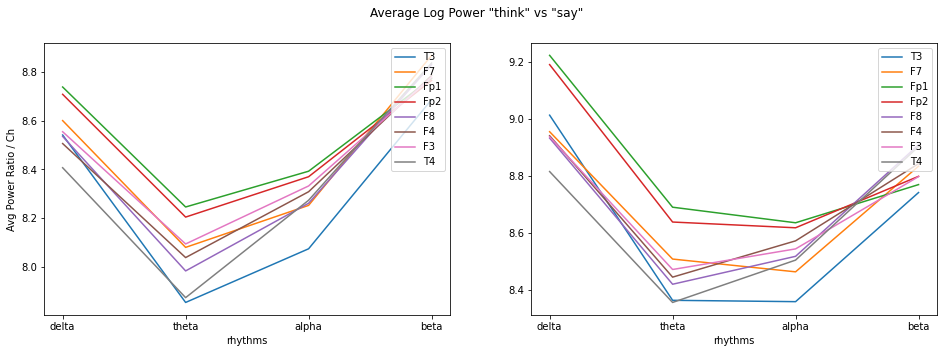

In [9]:
binning = [1, 4, 7, 12, 30]
rhythms = ['delta', 'theta', 'alpha', 'beta']

def get_log_powers(segment_data, bins=[], fs=250):
    """Get the powers associated with each channel
        during a segment of data
    """
    chs_pwr = []
    for ch in segment_data:
        power, _ = pyeeg.bin_power(ch, bins, fs)
        chs_pwr.append(np.log(power))
        
    return chs_pwr

def avg_power_per_ch(ev_epochs, bins=[], fs=250):
    """Gets the power for each channel in each
        epoch. Then averages the power across all
        epochs, returning the channel average for all epochs.
    """
    all_pwr = []
    for epoch in ev_epochs:
        epoch_pwr = get_log_powers(epoch, bins, fs)
        all_pwr.append(epoch_pwr)

    all_pwr = np.array(all_pwr)
    ch_avg = np.mean(all_pwr[:,:], 0)
    
    return ch_avg
        
think_pwr_avg = avg_power_per_ch(think, binning, fs)
say_pwr_avg = avg_power_per_ch(say, binning, fs)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
fig.suptitle('Average Log Power "think" vs "say"')

for ch, values in zip(channels, think_pwr_avg):
    name = ch
    ax1.plot(rhythms, values, label=name)
    
ax1.set_xlabel('rhythms')
ax1.set_ylabel('Avg Power Ratio / Ch')
# ax1.title('Avg Power Ratio across "think" epochs')
ax1.legend(loc='upper right')

for ch, values in zip(channels, say_pwr_avg):
    name = ch
    ax2.plot(rhythms, values, label=name)
    
ax2.set_xlabel('rhythms')
# ax2.title('Avg Power Ratio across "say" epochs')
ax2.legend(loc='upper right')


### CSP - via MNE
**Note:** I would like to build my own, but running out of time.

## Classifier

Number of target instances: 35
Number of non_target instances: 102
(137, 8, 525)
137 137
SHAPES X: (137, 8, 525) Y: (137,)
Classification accuracy: 0.753571 / Chance level: 0.744526


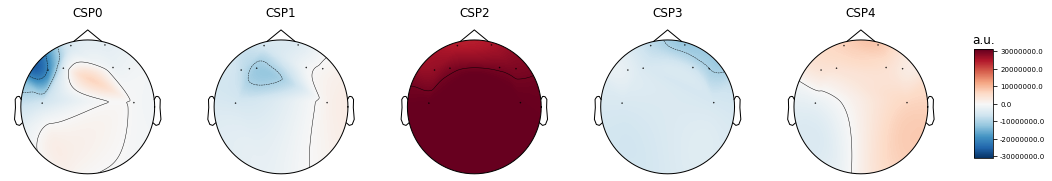

In [10]:
from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
import mne
mne.set_log_level(verbose=False)

ch_types = ['eeg'] * len(channels)
info = mne.create_info(ch_names=channels, sfreq=fs, ch_types=ch_types)
raw = mne.io.RawArray(sorted_data[1:9], info)
montage = make_standard_montage('standard_1020')
raw.set_montage(montage)

# 1:say, 2:think, 3:visualize, 4:talking
trgt_ev = 2
# epochs = np.array(epoched_data)
non_target = epochs[np.where(events[:,2] != trgt_ev)]
target = epochs[np.where(events[:,2] == trgt_ev)]
        
print('Number of target instances:', len(target))
print('Number of non_target instances:', len(non_target))

Y = np.zeros(len(epochs))
Y[np.where(events[:,2] == trgt_ev)] = 1
print(epochs.shape)
print(len(epochs), len(Y))

i_pos = np.array(range(len(epochs)))
np.random.seed(22)
np.random.shuffle(i_pos)
X_shuffled = [epochs[i] for i in i_pos]
Y_shuffled = [Y[i] for i in i_pos]
X_shuffled = np.array(X_shuffled)
Y_shuffled = np.array(Y_shuffled)
print('SHAPES X:', X_shuffled.shape, 'Y:', Y_shuffled.shape)

scores = []
cv = ShuffleSplit(10, test_size=0.2, random_state=22)
cv_split = cv.split(X_shuffled)

lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=5, reg=None, log=False, norm_trace=False)

clf = Pipeline([('CSP', csp), ('LDA', lda)])
scores = cross_val_score(clf, X_shuffled, Y_shuffled, cv=cv, n_jobs=-1)


class_balance = np.mean(Y_shuffled == Y_shuffled[0])
class_balance = max(class_balance, 1. - class_balance)
print('Classification accuracy: %f / Chance level: %f' % (np.mean(scores), class_balance))

csp.fit_transform(epochs, Y)

fig = csp.plot_patterns(raw.info, size=1.8, res=144)

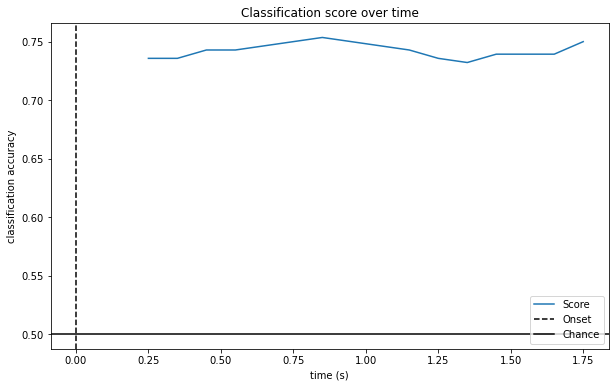

In [11]:
w_length = int(fs * 0.5)   # running classifier: window length
w_step = int(fs * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs.shape[2] - w_length, w_step)

scores_windows = []

for train_idx, test_idx in cv_split:
    y_train, y_test = Y_shuffled[train_idx], Y_shuffled[test_idx]

    X_train = csp.fit_transform(X_shuffled[train_idx], y_train)
    X_test = csp.transform(X_shuffled[test_idx])

    # fit classifier
    lda.fit(X_train, y_train)

    # running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        X_test = csp.transform(X_shuffled[test_idx][:, :, n:(n + w_length)])
        score_this_window.append(lda.score(X_test, y_test))
    scores_windows.append(score_this_window)

# Plot scores over time
w_times = (w_start + w_length / 2.) / fs - 0

plt.figure(figsize=(10,6))
plt.plot(w_times, np.mean(scores_windows, 0), label='Score')
plt.axvline(0, linestyle='--', color='k', label='Onset')
plt.axhline(0.5, linestyle='-', color='k', label='Chance')
plt.xlabel('time (s)')
plt.ylabel('classification accuracy')
plt.title('Classification score over time')
plt.legend(loc='lower right')
plt.show()